In [1]:
%matplotlib inline
from pprint import pprint
import itertools

from market import Returns_US_1871
from simulate import simulate_withdrawals
from harvesting import N_60_RebalanceHarvesting
from metrics import average, mean, median
from portfolio import Portfolio
from plot import plot, plot_two

from decimal import getcontext, Decimal
getcontext().prec = 8


"""
Always buy stocks with new money, never bonds.  Prime harvesting will
convert stocks to bonds later.

The prime harvesting 20% rise calculation must use the unit price of
the stock portfolio to avoid distortions from new money entering the
portfolio.  Unfortunately this adds bookkeeping overhead if the stock
portfolio consists of multiple funds but it's easy if you use a single
global equity index tracker fund (FTSE All-World, etc).

Skip prime harvesting if bonds exceed your retirement portfolio
allocation (e.g. 60% stocks/40% bonds).  This limits the drag caused
by bonds, especially if you start off accumulation with years of
strong stock performance.
"""

"\nAlways buy stocks with new money, never bonds.  Prime harvesting will\nconvert stocks to bonds later.\n\nThe prime harvesting 20% rise calculation must use the unit price of\nthe stock portfolio to avoid distortions from new money entering the\nportfolio.  Unfortunately this adds bookkeeping overhead if the stock\nportfolio consists of multiple funds but it's easy if you use a single\nglobal equity index tracker fund (FTSE All-World, etc).\n\nSkip prime harvesting if bonds exceed your retirement portfolio\nallocation (e.g. 60% stocks/40% bonds).  This limits the drag caused\nby bonds, especially if you start off accumulation with years of\nstrong stock performance.\n"

In [2]:
def sim_reb(series, years=30):
    pv = []

    portfolio = Portfolio(0, 0)
    inflation = Decimal('1')
    
    def buy(amount):
        portfolio.deposit_cash(amount)
        portfolio.buy_stocks(amount)
        
    def rebalance():
        portfolio.sell_stocks(portfolio.stocks)
        portfolio.sell_bonds(portfolio.bonds)
        portfolio.buy_stocks(portfolio.value * Decimal('.6'))
        portfolio.buy_bonds(portfolio._cash)

        
    # make our first purchase
    buy(5000)
    rebalance()
    
    for _, d in zip(range(years), series):
        # Adjust for annual returns
        portfolio.adjust_returns(d)
        inflation *= (1 + d.inflation)

        # Buy new stocks
        buy(5000 * inflation)
        
        # Rebalance to 60/40
        rebalance()

        pv.append(portfolio.value)

    return pv

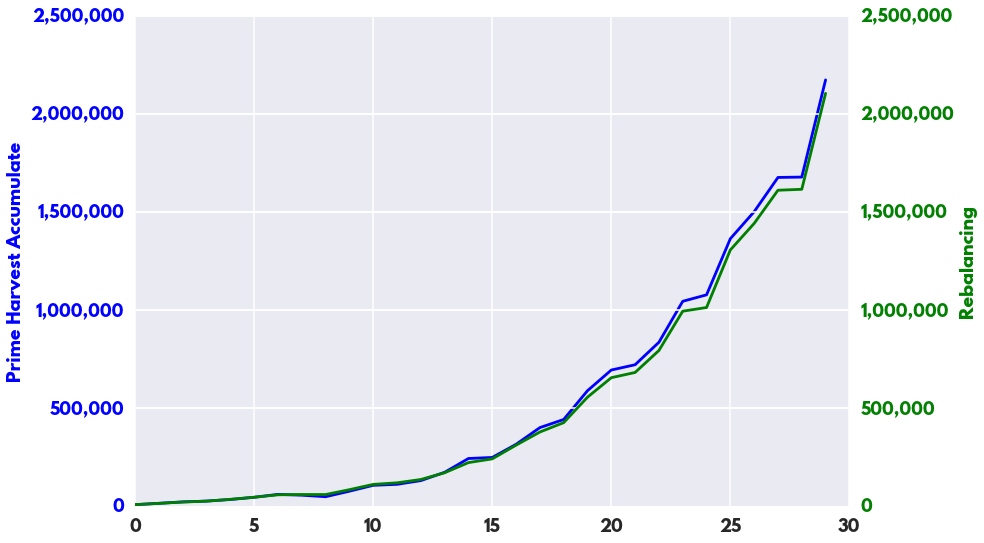

In [3]:
def sim_prime(series, years=30):
    pv = []
    portfolio = Portfolio(0, 0)
    index = Decimal('1')
    cost_basis = 0
    shares = 0
    
    def buy(amount):
        nonlocal cost_basis, shares, portfolio
        portfolio.deposit_cash(amount)
        portfolio.buy_stocks(amount)
        cost_basis += amount
        shares += (amount / index)
        
    # make our first purchase
    buy(5000)
    
    inflation = Decimal('1')

    for _, d in zip(range(years), series):
        # Adjust for annual returns
        portfolio.adjust_returns(d)
        index *= (1 + d.stocks)
        inflation *= (1 + d.inflation)
        cost_basis *= (1 + d.inflation)
        
        # Check if we need to harvest stocks
        to_sell = portfolio.stocks * Decimal('.2')
        harvested = index / (cost_basis / shares) > 1.2
        under_bond_limit = (portfolio.bonds / portfolio.value) < .4
        if harvested and under_bond_limit:
            #print('Harvested %d of stocks. %f' % (to_sell, portfolio.bonds / portfolio.value))
            portfolio.sell_stocks(to_sell)
            portfolio.buy_bonds(to_sell)
            
            # need to adjust cost basis and shares
            shares -= (to_sell / index)
        if not harvested: to_sell = 0

        # Buy new stocks
        buy(5000 * inflation)
        
        pv.append(portfolio.value)
        #pv.append((portfolio.stocks, portfolio.bonds, harvested, to_sell, d.stocks, 5000*inflation))
    return pv 

def one():
    r = Returns_US_1871()
    p1 = sim_prime(r.iter_from(1980))
    print("{:,}".format(p1[-1][0] + p1[-1][1]))
    from plot import plot
    plot([n[1] / (n[0] + n[1]) for n in p1], title='Bond %')
    
def two():
    r = Returns_US_1871()
    (r1, r2) = itertools.tee(r.iter_from(1966))
    p1 = sim_prime(r1)
    p2 = sim_reb(r2)
    from plot import plot_two
    plot_two(p1, p2, s1_title='Prime Harvest Accumulate', s2_title='Rebalancing')
    
two()

1,145,218.9


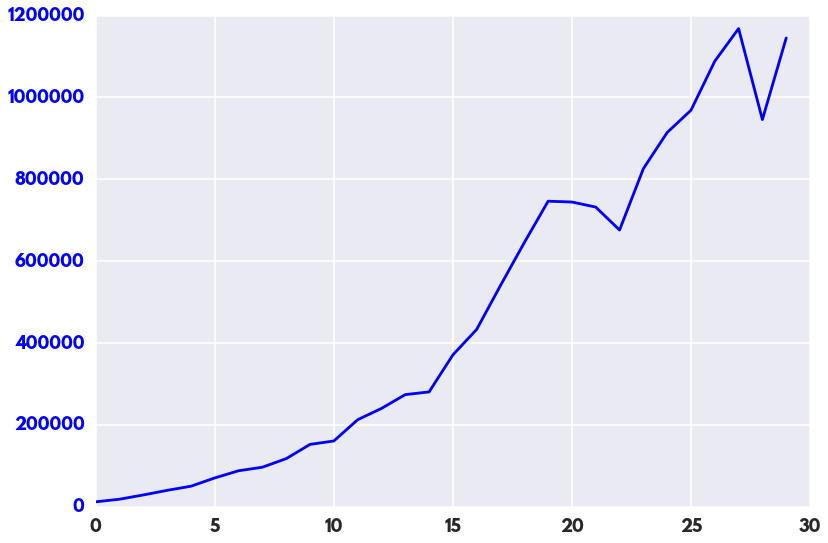

In [4]:
r = Returns_US_1871()
p2 = sim_reb(r.iter_from(1980))
print("{:,}".format(p2[-1]))
plot(p2)

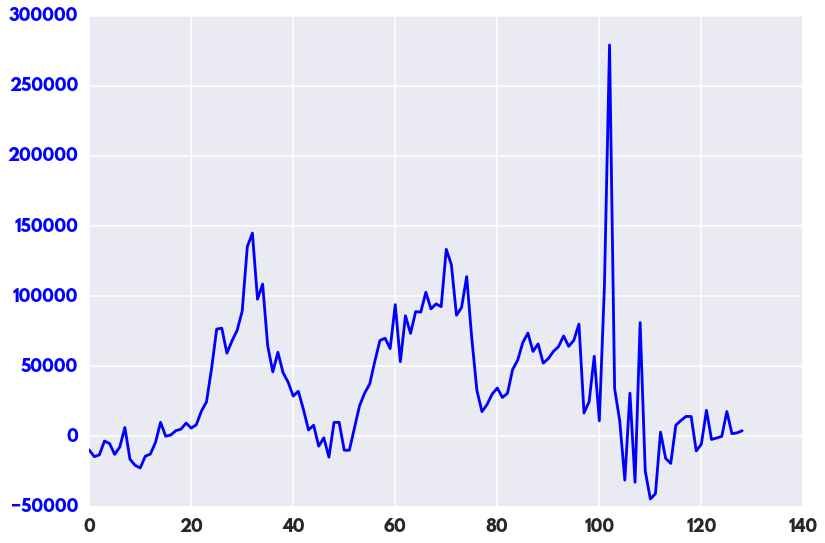

36296.571627906982

In [6]:
pv = []
for y in range(1871, 2000):
    (r1, r2) = itertools.tee(r.iter_from(y))
    p1 = sim_prime(r1)
    p2 = sim_reb(r2)
    diff = (p1[-1] - p2[-1])
    pv.append(diff)
plot(pv)
average(pv)